## 0. Libraries & Configurations

EDA 실행에 필요한 library를 설치하고 경로를 지정합니다.

In [69]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd

import cv2
from PIL import Image
from tqdm.notebook import tqdm
from time import time

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import multiprocessing as mp

In [70]:
class cfg:
    data_dir = '/opt/ml/input/data/train'  
    img_dir = f'{data_dir}/images'
    df_path = f'{data_dir}/train.csv'

In [71]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3',
             'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}

df = pd.read_csv(cfg.df_path)
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [72]:
is_female = df['gender'] == 'female'
female = df[is_female]
print(len(female))

1658


---

## 1. Data Bias

Data 분포도를 알아보기 위해 각 label별 이미지의 개수를 알아보고, matplotlib을 이용해 시각화했습니다.

* gender

In [73]:
# label별 분포 (gender)

is_female = df['gender'] == 'female'
is_male = df['gender'] == 'male'

female = len(df[is_female])
male = len(df[is_male])

print(f"male data: {male} | female data: {female}")

male data: 1042 | female data: 1658


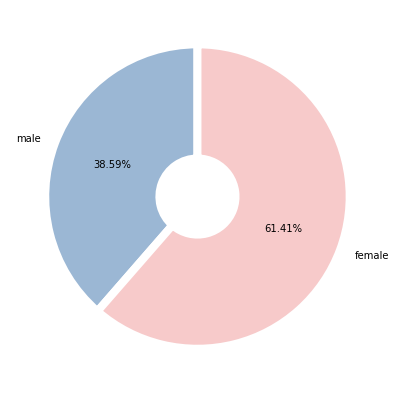

In [74]:
# 원형 그래프로 시각화

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

values = [male, female]
labels = ['male', 'female']
colors = ["#9BB7D4", "#F7CACA"]

wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 8}
ax.pie(values, labels = labels, startangle=90, autopct='%.2f%%', colors = colors, wedgeprops=wedgeprops)
plt.show()

* age

In [75]:
# label별 분포 (age)

is_under_30 = df['age'] < 30
is_between = df['age'] < 60
is_over_60 = df['age'] >= 60

under_30 = len(df[is_under_30])
between = len(df[is_between]) - under_30
over_60 = len(df[is_over_60])

print(f"under 30: {under_30} | 30~59: {between} | over 60: {over_60}")

under 30: 1281 | 30~59: 1227 | over 60: 192


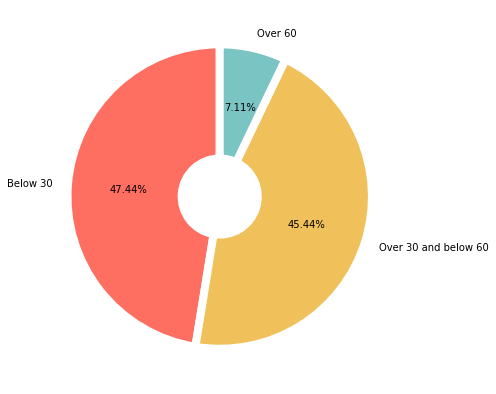

In [76]:
# 원형 그래프로 시각화

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

values = [under_30, between, over_60]
labels = ['Below 30', 'Over 30 and below 60', 'Over 60']
colors = ["#FF6F61", "#F0C05A", "#7BC4C4"]

wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 8}
ax.pie(values, labels = labels, startangle=90, autopct='%.2f%%', colors = colors, wedgeprops=wedgeprops)
plt.show()

* Gender & Age

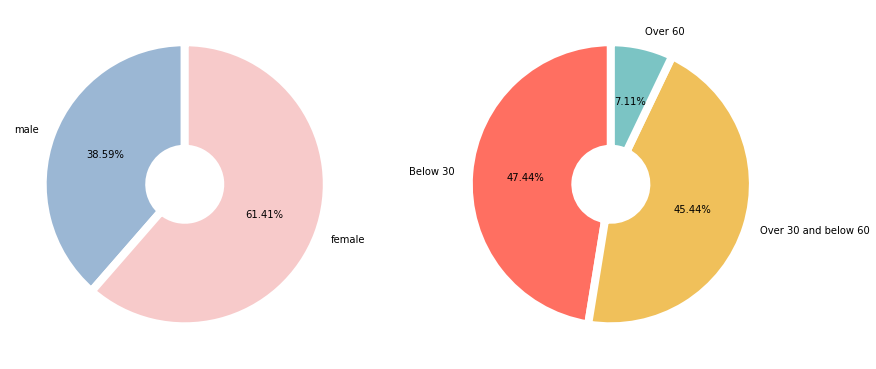

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(14, 28))

values = [male, female]
labels = ['male', 'female']
colors = ["#9BB7D4", "#F7CACA"]

values_ = [under_30, between, over_60]
labels_ = ['Below 30', 'Over 30 and below 60', 'Over 60']
colors_ = ["#FF6F61", "#F0C05A", "#7BC4C4"]

wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 8}
ax[0].pie(values, labels = labels, startangle=90, autopct='%.2f%%', colors = colors, wedgeprops=wedgeprops)
ax[1].pie(values_, labels = labels_, startangle=90, autopct='%.2f%%', colors = colors_, wedgeprops=wedgeprops)

plt.show()

In [78]:
# gender와 age의 상관관계

Female_Age = {"~20" : 0, "20~29" : 0, "30~39" : 0, "40~49" : 0, "50~59" : 0, "60~" : 0 }
Male_Age = {"~20" : 0, "20~29" : 0, "30~39" : 0, "40~49" : 0, "50~59" : 0, "60~" : 0 }

for idx in range(len(df)) :
    person = df.iloc[idx]
    if person['gender'] == 'female' :
        if person['age'] <= 20 : Female_Age["~20"] += 1
        elif 20 < person['age'] < 30 : Female_Age["20~29"] += 1
        elif 30 < person['age'] < 40 : Female_Age["30~39"] += 1
        elif 40 < person['age'] < 50 : Female_Age["40~49"] += 1
        elif 50 < person['age'] < 60 : Female_Age["50~59"] += 1
        elif 60 <= person['age'] : Female_Age["60~"] += 1
    elif person['gender'] == 'male' :
        if person['age'] <= 20 : Male_Age["~20"] += 1
        elif 20 < person['age'] < 30 : Male_Age["20~29"] += 1
        elif 30 < person['age'] < 40 : Male_Age["30~39"] += 1
        elif 40 < person['age'] < 50 : Male_Age["40~49"] += 1
        elif 50 < person['age'] < 60 : Male_Age["50~59"] += 1
        elif 60 <= person['age'] : Male_Age["60~"] += 1

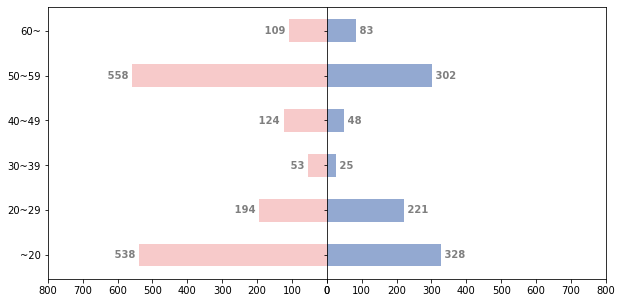

In [79]:
# 가로 그래프로 시각화

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5), gridspec_kw={"wspace":0})

female = np.array(("~20", "20~29", "30~39", "40~49", "50~59", "60~"))
female_values = list(Female_Age.values())
axs[0].barh(female, female_values, color="#F7CACA", height = 0.5)

male = np.array(("~20", "20~29", "30~39", "40~49", "50~59", "60~"))
male_values = list(Male_Age.values())
axs[1].barh(male, male_values, color="#93A9D1", height = 0.5)

xmax = 800
axs[0].set_xlim(xmax, 0)
axs[1].set_xlim(0, xmax)

for ax in axs:
    for i, p in enumerate(ax.patches):
        w = p.get_width()
        if ax == axs[0]:
            ha = "right"
        else:
            ha = "left"
        
        ax.text(w, i, f" {format(w, ',')} ", 
                fontsize=10, va="center", ha=ha, 
                fontweight="bold", alpha=0.5)

plt.show()

* 18개의 label별 Data 분포

In [80]:
data_dir = '/opt/ml/input/data/train/images/*/'

In [81]:
def check_mask(path): 
    if 'mask' in path and 'incorrect' not in path: 
        return list(range(0, 6)) # 0~5 중에 하나 
    elif 'incorrect' in path: 
        return list(range(6, 12)) # 6~11 
    else: 
        return list(range(12, 18)) # 12~17 

In [82]:
def check_gender(path): 
    if 'female' in path: 
        return [3, 4, 5, 9, 10, 11, 15, 16, 17]
    else: 
        return [0, 1, 2, 6, 7, 8, 12, 13, 14]

In [83]:
def check_age(path): 
    split_folder = path.split('/')
    name = split_folder[7].split('_')
    age = int(name[3])

    if age < 30: 
        return [0, 3, 6, 9, 12, 15]
    elif 30 <= age < 60: 
        return [1, 4, 6, 10, 13, 16]
    else: 
        return [2, 5, 8, 11, 14, 17]

In [84]:
folders = glob(data_dir, recursive=True) 
distribution = [0] * 18

for folder in folders: 
    for file in glob(os.path.join(folder, '**')): 
        mask = check_mask(file) 
        gender = check_gender(file)
        age = check_age(file) 

        mask_gender = list(set(mask).intersection(gender))
        mask_gender_age = set(mask_gender).intersection(age)
        distribution[mask_gender_age.pop()] += 1

In [85]:

label = ['mask_male_under', 
        'mask_male_between', 
        'mask_male_over', 
        'mask_female_under', 
        'mask_female_between', 
        'mask_female_over', 
        'incorrect_male_under',
        'incorrect_male_between', 
        'incorrect_male_over', 
        'incorrect_female_under',
        'incorrect_female_between', 
        'incorrect_female_over',
        'normal_male_under', 
        'normal_male_between', 
        'normal_male_over', 
        'normal_female_under', 
        'normal_female_between', 
        'normal_female_over']

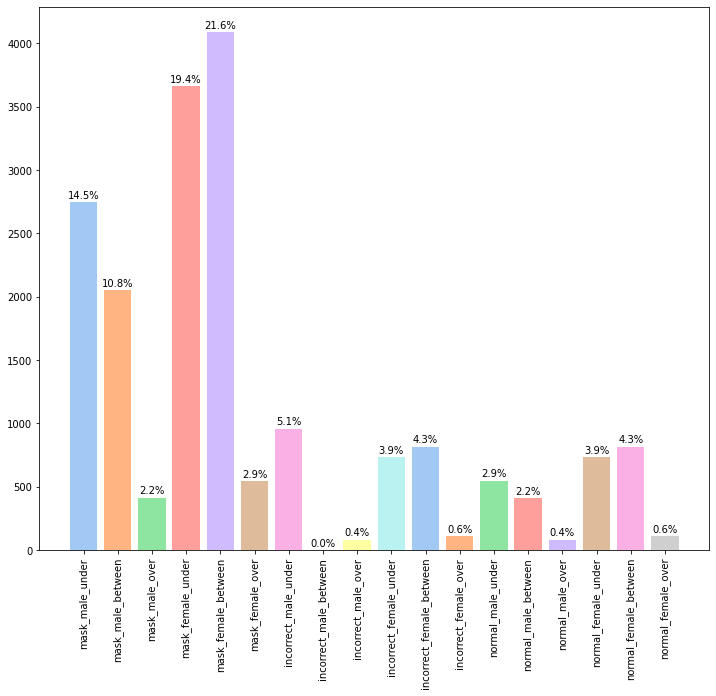

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

x = list(range(0, 18))
total = np.sum(distribution) 
palette = sns.color_palette("pastel", as_cmap=True)

ax.bar(label, distribution, color = palette) 
for i, v in enumerate(distribution): 
    ax.text(i, v+30, '%.1f%%' % (v / total * 100), horizontalalignment = 'center', \
            size = 10, color='black')

plt.xticks(range(0, 18), rotation = 90)
plt.show()

---

## 2. Class distinction

## 3. Outlier

## 4. Noisy input